# introdução ao Scikit-Learn e avaliação do modelo

O que veremos neste caderno:

* Explicar a variável de resposta;

* Descrever as implicações de dados desbalanceados na classificação binária;

* Dividir os dados em conjuntos de treinamento e teste;

* Descrever o ajuste do modelo no scikit-learn;

* Derivar várias métricas para a classificação binária;

* Criar uma curva ROCe uma curva precision-recall.

Este caderno concluirá a análise exploratória incial e apresentará novas ferramentas para execução da avaliação do modelo.

Há vários critérios importantes para a avaliação de modelos que são considerados conhecimento padrão em ciência de dados e machine learning. Abordaremos aqui algumas das mais usadas métricas de desempenho de modelos de classificação, para construirmos uma base sólida.

## Examinando a variável de resposta e concluindo a exploração inicial

Nosso objetivo é criar um modelo preditivo que a variável de resposta seja uma flag SIM/NÃO. Esse problema se chama tarefa de **classificação binária**.

Em nossos dados rotulados, consideramos que as amostras (contas) que ficarão inadimplentes (isto é, com status **default payment next month** | falta de pagamento no próximo mês = 1) pertencem à **classe positiva**, enquanto as que ficarão pertencem à **classe negativa**.

A informação mais importante que devemos examinar com relação à resposta de um problema de classificação binária é: **QUAL É A PROPORÇÃO DA CLASSE POSITIVA?**



Antes de fazer essa verificação, precisamos carregarmos os pacotes requeridos neste caderno

In [1]:
import numpy as np                 # pacote para cálculos númericos
import pandas as pd                # pacote preparação dos dados
import matplotlib.pyplot as plt    # pacote de plotagem

# definições de renderização de plotagens
%matplotlib inline
import matplotlib as mpl           # adiciona a funcionalidade de plotagem
mpl.rcParams['figure.dpi'] = 400   # figuras em alta resolução

Agora, precisamos importar a versão limpa dos dados trabalhados no caderno anterior

In [2]:
df = pd.read_csv('C:/Users/Renato/Dropbox/pos_usp/usp_data_open/data_science/projetos_de_ciencias_de_dados_com_python/Data/Chapter_1_cleaned_data.csv')

In [3]:
# Verificando dados da importação do dataset

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,EDUCATION_CAT,graduate school,high school,others,university
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,1,university,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,1000,1000,0,2000,1,university,0,0,0,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,1000,1000,1000,5000,0,university,0,0,0,1
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,1200,1100,1069,1000,0,university,0,0,0,1
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,10000,9000,689,679,0,university,0,0,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26664 entries, 0 to 26663
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          26664 non-null  object
 1   LIMIT_BAL                   26664 non-null  int64 
 2   SEX                         26664 non-null  int64 
 3   EDUCATION                   26664 non-null  int64 
 4   MARRIAGE                    26664 non-null  int64 
 5   AGE                         26664 non-null  int64 
 6   PAY_1                       26664 non-null  int64 
 7   PAY_2                       26664 non-null  int64 
 8   PAY_3                       26664 non-null  int64 
 9   PAY_4                       26664 non-null  int64 
 10  PAY_5                       26664 non-null  int64 
 11  PAY_6                       26664 non-null  int64 
 12  BILL_AMT1                   26664 non-null  int64 
 13  BILL_AMT2                   26664 non-null  in

Para encontrar a proporção da classe postiva, precisamos apenas obter a média da variável de resposta no dataset inteiro

In [5]:
df['default payment next month'].mean()

0.2217971797179718

Acima saída da taxa de inadiplência.

Também é útil verificar o número de amostras em cada classe.

In [6]:
# Balanceamento de classes da variável de resposta

df.groupby('default payment next month')['ID'].count()

default payment next month
0    20750
1     5914
Name: ID, dtype: int64

A média das contas que ficaram inadimplentes é de 22%, o que representa 5914 contas do portfólio (de acordo com a operação **[groupby/count](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.count.html)**).

A proporção de amostras na classe positiva (inaimplência = 1), também chamada de **fração da classe**, é uma estatística importante.

Na classificação binária, os datasets são descritos considerando-se se eles são **balanceados** ou **desbalanceados**.

A maioria dos modelos de classificação de machine learning é projetada para operar com dados balanceados: uma divisão 50/50 entre as classes.

Na prática, raramente essa divisão (50/50) é alcançada. Assim, há vários métodos que têm como objetivo lidar com dados desbalanceados. São eles:

- **Subamostragem (undersampling)** da classe majoritária: eliminar aleatoriamente amostras da classe majoritária até as frações serem iguais (ou menos desbalanceadas);
- **Sobreamonstragem (oversampling)** da classe minoritária: adicionar aleatoiamente amostras duplicadas da classe minoritáia para atingir o mesmo objetivo;
- **Ponderação de amostragem (weighting samples)**: esse método é executado como parte da etapa de treinamento, para que a classe minoritária receba coletivamente a mesma 'ênfase' da classe majoritária no modelo ajustado. O efeito é o mesmo do oversampling).



# Introdução ao scikit-learn

Scikit-learn é um dos pricipais pacotes de machine learning para Python (com exceção dos de deep learning).

Nesta seção, será ilustrado a sintaxe usando um modelo de **regressão logística**. Regressão logística é um dos mais simples modelos de classificação (examinaremos os detalhes matemáticos e seu funcionamento mais adiante).



Anteriormente, nos familiarizamos com o conceito de treinar um algoritmo a partir de dados para usar o modelo treinado a fim de fazer previsões com novos dados.

O scikit-learn encapsulo essas funconalidades b´saicas no método **.fit** para treinamento de modelos e no método **.predict** para a execução de previsões.

Devido à sintaxe consistente, você pode chamar **.fit** e **.predict** em qualquer modelo do scikit-learn, seja de regressão linear ou de árvores de classificação.



A primeira etapa é selecionar algum modelo, nesse exemplo uma **regressão logística**, e instanciá-lo a partir da **classe** fornecida pelo scikit-learn disponibilizada e criando um **objeto** útil a partir dele.

Podemos treinar esse objetivo com seus dados e salvá-lo em disco para uso posterior.

Primeiro temos que importar a classe:

In [7]:
#Import the class

from sklearn.linear_model import LogisticRegression

O código que instancia a **classe** para criar um objeto é:

In [8]:
#Create an object

my_lr = LogisticRegression()

In [9]:
#Examine it

my_lr

LogisticRegression()

Na saída acima deveria conter uma extensa saída (a saída deveria ser a mesma da linha abaixo). 

In [10]:
# Instancie ao especificar argumentos de palavra-chave

my_new_lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#5/2020: updated multi_class='warn' to multi_class='auto'

Ainda que o objeto que criamos aqui em **my_new_lr** seja idêntico a **my_lr**, agir dessa maneira explícita será particularmente útil quando estivermos começando a travar contato com diferentes tipos de modelos.

Quando estiver mais familizarido, poderemos executar a instanciação com as opções padrão e fazer alterções posteriormente conforme necessário.

*Há uma explicação na página 73 do livro de como alterar este padrão.*

In [11]:
my_new_lr.C = 0.1
my_new_lr.solver = 'liblinear'

_______________

Como sabemos, os algoritmos de aprendizado supervisionado dependem de dados rotulados. 

Isso significa que pecisamos tanto das características, normalmente contidas em uma variável **X**, quando das respostas correspondentes, em uma variável chamada **y**.

Tomaremos emprestadas de nosso dataset as 10 primeiras linhas amostras de uma única característica, e a resposta, para ilustrar

In [12]:
X = df['EDUCATION'][0:10].values.reshape(-1,1)

X

array([[2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [1],
       [2],
       [3],
       [3]], dtype=int64)

Os 10 primeiros valores correspondentes da variável de resposta podemser obtidos assim:


In [13]:
y = df['default payment next month'][0:10].values

y

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

O scikit-learn espera que a primeira dimensão (isto é, o número de linhas) do array de característcas seja o número de amostras, logo, tivemos de fazer esse redimensionamento para X, mas não para y.

Agora usaremos esses dados para ajustar nossa regressão logística. Isso pode ser feito com uma única linha:

In [14]:
# ajustando um modelo no scikit-learn

my_new_lr.fit(X, y)

LogisticRegression(C=0.1, solver='liblinear')

Agora o objetivo de modelo **my_new_lr** é um modelo treinado.

Podemos dizer que essa alteração ocorreu **in loco**, já que não foi criado um novo objeto. 

Já podemos usar nosso modelo reinado para fazer previsões para novas características que o modelo ainda não 'viu'. Tentaremos usar as p´roximas 10 linhas da característica EDUCATION.

In [15]:
new_X = df['EDUCATION'][10:20].values.reshape(-1,1)

new_X

array([[3],
       [1],
       [2],
       [2],
       [1],
       [3],
       [1],
       [1],
       [1],
       [3]], dtype=int64)

As previsções são feitas assim:

In [16]:
# previsões para as novas características

my_new_lr.predict(new_X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

Também podemos visualizar quais são os valores reais correspondentes a essas previsões:


In [17]:
df['default payment next month'][10:20].values

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0], dtype=int64)

Observe qye o único argumento desse método é um conjunto de características, isto é,  um **X** que chamamos de **new_X**. Nesse caso, não foi fornecido um **y**. Na verdade, é para isso que serve a modelagem preditiva: você não sabe necessariamente o valor verdadeiro da variável de resposta, logo, tem de poder prevê-lo

# Gerando dados sintéticos

No próximo exercício, percorreremos por conta própria o processo de ajuste de um modelo.

In [18]:
# Criando números aleatórios uniformementes distribuídos com o NumPy

np.random.seed(seed=1)
X = np.random.uniform(low=0.0, high=10.0, size=(1000,))

X[0:10]

array([4.17022005e+00, 7.20324493e+00, 1.14374817e-03, 3.02332573e+00,
       1.46755891e+00, 9.23385948e-01, 1.86260211e+00, 3.45560727e+00,
       3.96767474e+00, 5.38816734e+00])

## Dados para uma regressão linear

Agora precisamos de uma variável de resposta. 

Para este exemplo, geraremos dados que se baseiam nas suposições da regressão linear: obedecem a uma tendência linear, mas tem erros normalmente distribuídos.

**Teoricamente, a regressão linear só deve ser usada para modelar dados em que a resposta seja uma transformação linear das características, com ruídos normalmente distribuídos**.


In [19]:
# código para a criação dos dados lineares com ruídos gaussiano

np.random.seed(seed=1)
slope = 0.25
intercept = -1.25

y = slope * X + np.random.normal(loc=0.0, scale=1.0, size=(1000,)) + intercept

y[0:10]

array([ 1.41690038, -0.06094518, -1.77788582, -1.56713719, -0.01770264,
       -3.32069221,  0.96046229, -1.14730508,  0.06095778, -0.15232854])

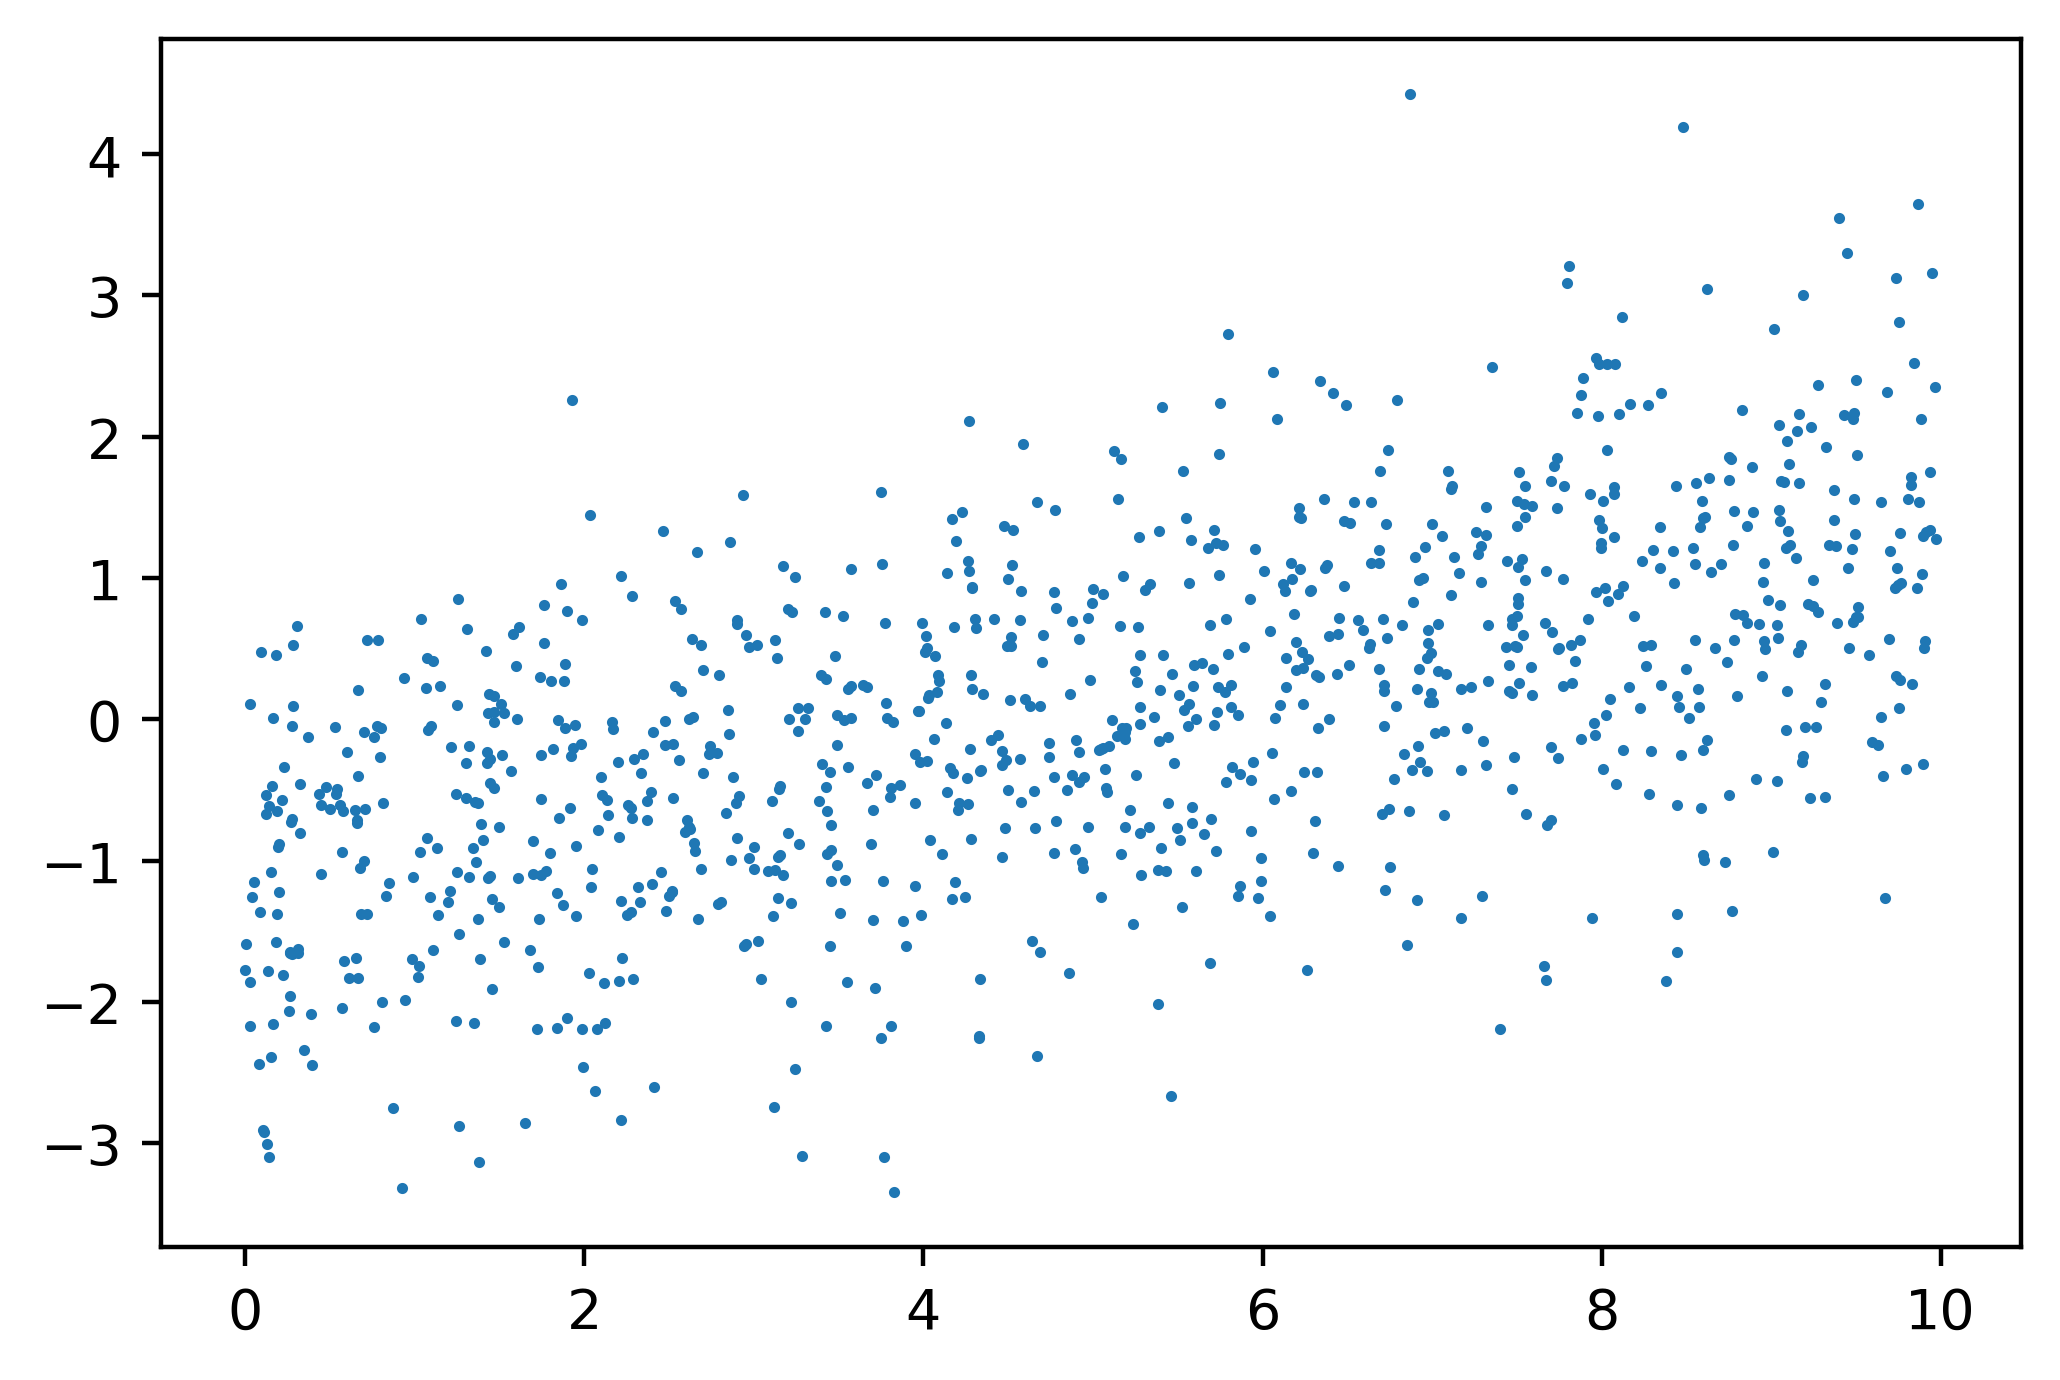

In [20]:
# agora queremos visualizar os dados

mpl.rcParams['figure.dpi'] = 400
plt.scatter(X,y,s=1)

Acima temos o plote do relacionamento linear ruidoso

# Exercício 8 - regressão linear com o scikit-learn

Agora, pegaremos os dados sintéticos que acabamos de gerar e determinaremos uma linha de melhor ajuste, ou **regressão linear**, usando o scikit-learn.

In [21]:
# importando a classe de modelo de regressão linear e instanciá-la

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

lin_reg

LinearRegression()

A saída do livro é:

```python
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
```

Como em qualquer outra classe de modelo, precisamos observar todas as opções padrão. Repare que para uma regressão linear, não há tantas opções padrão. 

In [22]:
# ajustando o modelo e examinando os coeficientes

lin_reg.fit(X.reshape(-1,1), y)

print(lin_reg.intercept_)
print(lin_reg.coef_)

-1.161256600282589
[0.24002588]


In [23]:
# fazendo previsões de valores das caracteríticas

y_pred = lin_reg.predict(X.reshape(-1,1))

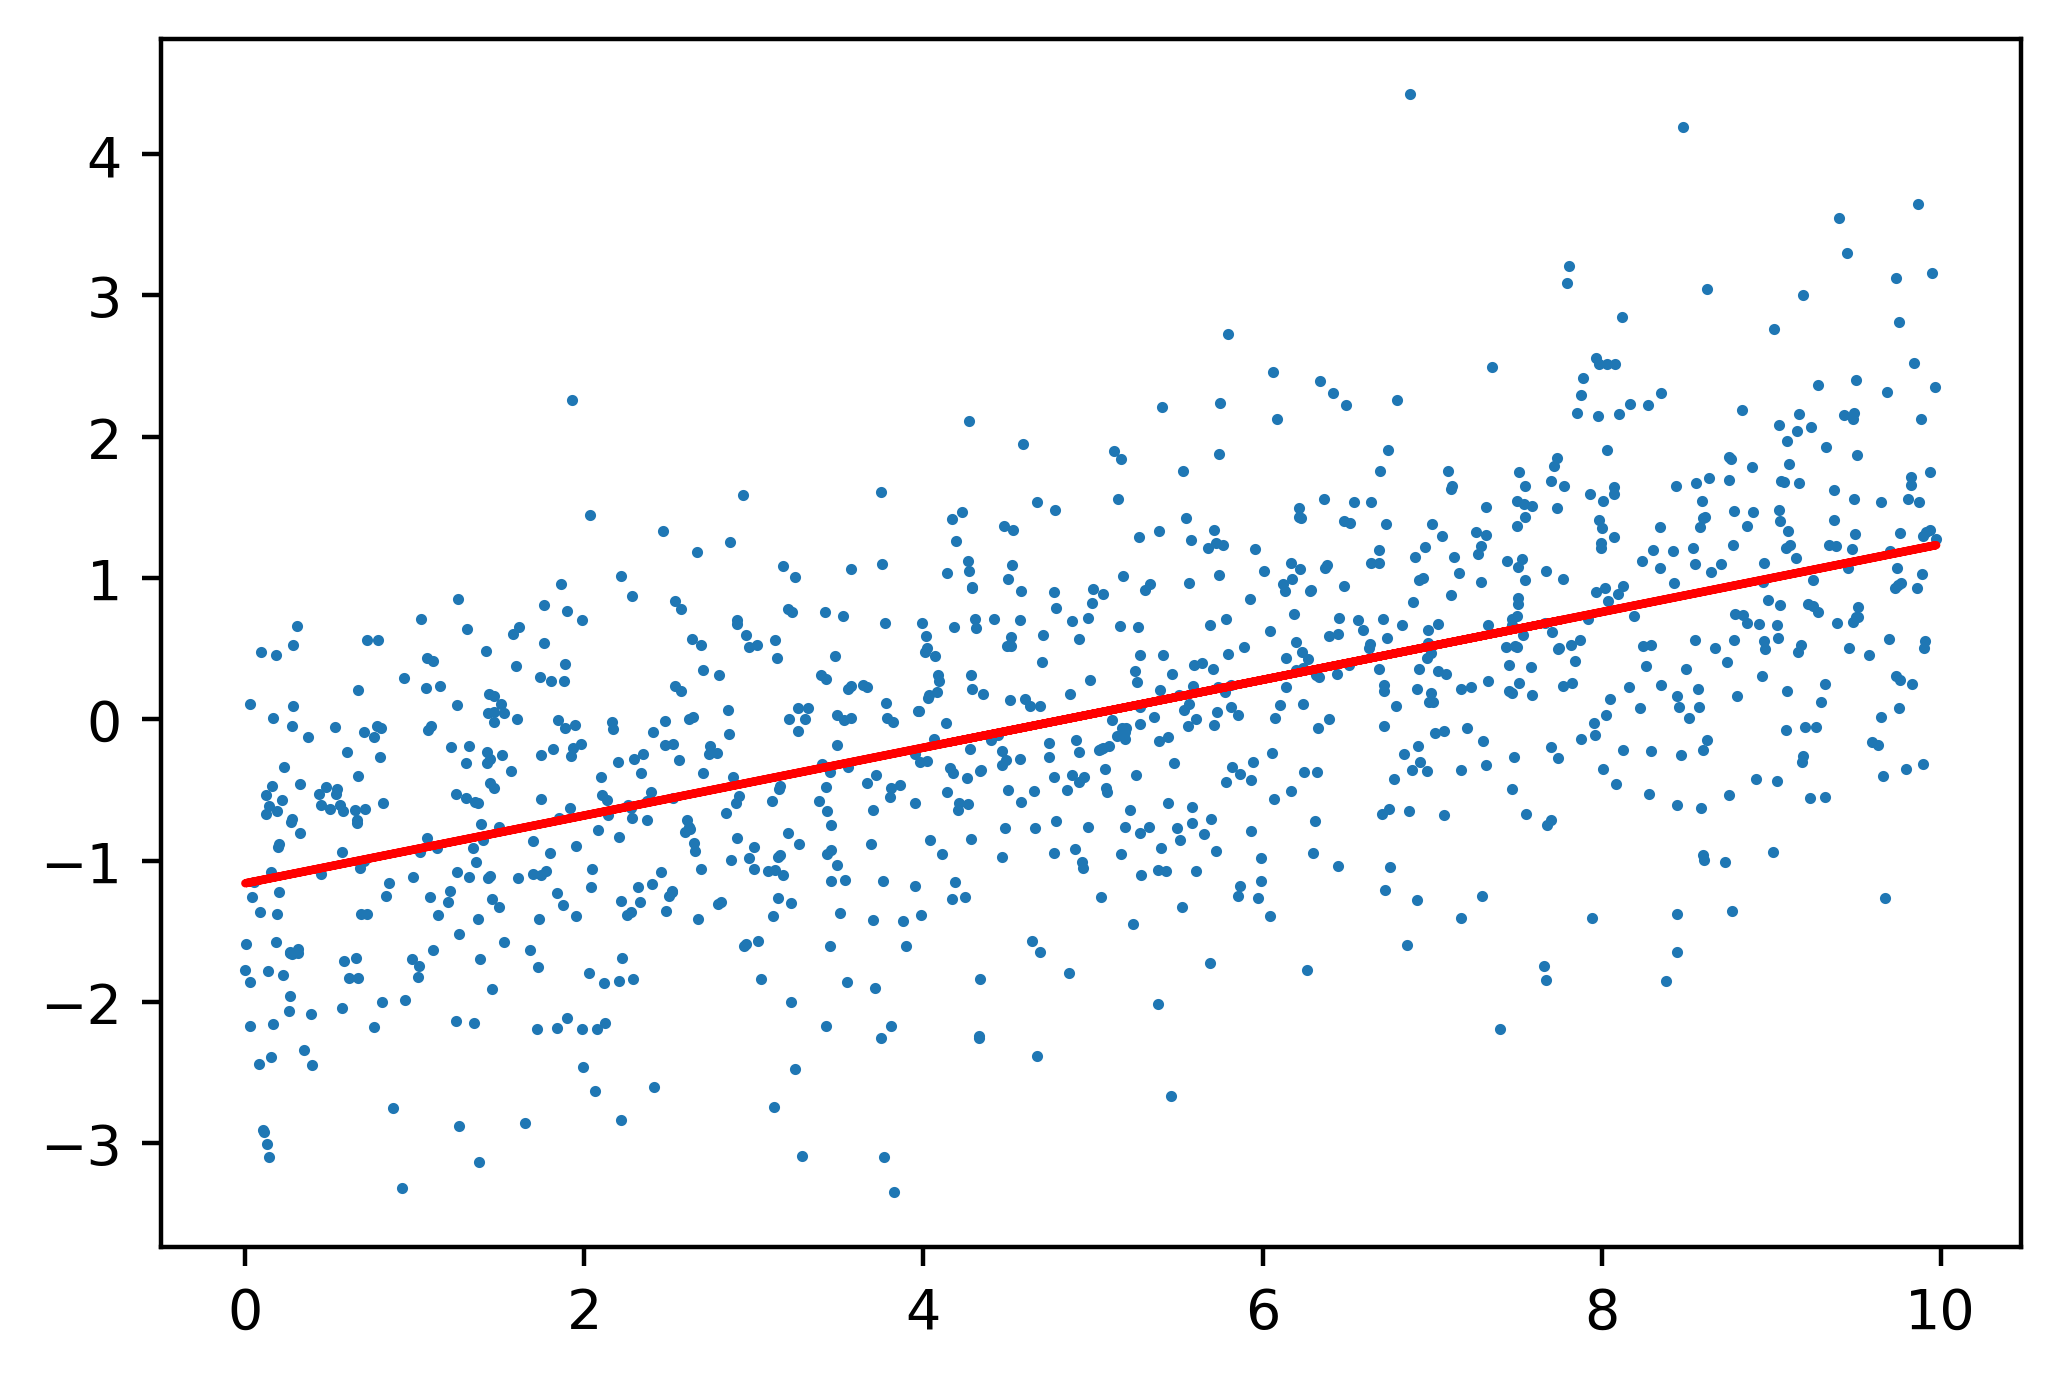

In [24]:
# Exibindo as previsões, y_pred, da característica X como uma plotagem linear a plotagem dispersa dos dados

plt.scatter(X,y,s=1)
plt.plot(X,y_pred, 'r') # 'r' dá a linha a cor vermelha

A plotagem exibe como seria a linha de melhor ajuste para os dados, como esperávamos

Nesse exercício, ao contrário de quando chamamos **.predict** com a **refressão logística**, fizemos previsões para os mesmos dados **X** que usamos para treinar o modelo.

Essa é uma diferença importante. Enquanto no caso atual estamos vendo como o modelo **ajusta** os mesmos dados com os quais foi treinado, anteriormente examinamos previsões do modelo para dados **novos e desconhecidos**.

Em ML, geralmente o que nos interessa são os recursos preditivos: queremos modelos que nos ajudem a saber os possíveis resultados de futuros cenários. 

No entanto, no fim das contas as previsões tanto dos **dados de treinamento** usados para ajustar o modelo, quanto dos **dados de teste**, que não foram usados no ajuste, são importantes para entendermos o funcionamento do modelo.



# Métricas de desemepenho de modelos para a classificação binária

Antes de começar a construir modelos preditivos, devemos saber como podemos determinar, após criar um modelo, se ele é de alguma forma "bom".

Há uma grande variedade de métricas de desempenho de modelos para escolhermos.

Para conhecer as diversas opções acesse [aqui](https://scikit-learn.org/stable/modules/model_evaluation.html)

Ao selecionar uma métrica de desempenho é importante nos lembrarmos de duas coisas:

- **Conveniência da métrica para o problema**

Normalmente as métricas são definidas apenas para uma classe específica de problema, como de classificação ou regressão.

Para um problema de classificação binária, várias métricas podem representar a precisão da pergunta de respostas sim ou não que o modelo responde.

Por outro lado, as métricas de regressão visam medir o quanto uma previsão se aproximou do valor alvo.

- **A métrica responde à pergunta da empresa?**

Independentemente da classe de problemas na qual você estiver trabalhando, haverá muitas opções para a métrica. Qual é a correta? E, mesmo assim, como saber se um modelo é "suficientemente bom" em termos de métricas?

De certa forma, essa é uma pergunta subjetiva. No entanto, podemos ser objetivos ao considerar qual é a meta do modelo. Em um contexto empresarial, as metas típicas são gerar lucro ou reduzir perdas. Basicamente, voc~e precisa tornar complementares o problema da empresa, que com frequência está relacionado as questões financeiras, e a métrica que usará para julgar o modelo.

## Dividindo os dados: conjuntos de treinamento e de teste

Esta introdução ao scikit-lear servirá para entender o conceito de uso de um modelo treinado para fazer previsões para novos dados que o modelo ainda não tinha 'visto'.

**Este é um conceito básíco em modelagem preditiva**.

Em nossa tentativa de criar um modelo que tenha capacidade preditiva, precisamos de alguma maneira de medir com que eficiência o modelo pode fazer previsões para dados não usados para ajustá-lo.

Por exemplo:

Em nosso estudo de caso, quando entregarmos o modelo treinado para o cliente, ele gerará um novo dataset de características como as que temos agora, só que, em vez de se estenderem pelo perído de abril a setembro, elas irão de maio a outubro. O cliente usara o modelo com essas características para prever se as contas ficarão inadimplentes em novembro.

In [25]:
# usaremos train_test_split do scikit-learn para dividir os dados de modo que 80% sejam usados para
# treinamento e 20% sejam reservados para teste.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
df['EDUCATION'].values.reshape(-1,1), df['default payment next month'].values, 
test_size=0.2, random_state=24)

In [26]:
# Examinando as dimensões de nossos dados de treinamento e teste para ver se elas são as esperadas
# dimensão dos conjuntos de treinamento e teste

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21331, 1)
(5333, 1)
(21331,)
(5333,)


Obs.: Estamos usando uma única característica **EDUCATION** apenas para mostrar como dividir dados e calcular diferentes métricas de desempenho do modelo. 

Agora que temos nossos dados de treinamento e teste, temos de nos certificar se sua natureza é a mesma entre esses conjuntos. Especificamente, temos de saber se a fração da classe positiva é semelhante. 

In [27]:
# Fração das classes nos dados de treinamento e teste

print(np.mean(y_train))
print(np.mean(y_test))

0.223102526838873
0.21657603600225014


De acordo com a saída acima, as frações da classe positiva tanto nos dados de treinamento quanto nos de teste são de aproximadamente 22%. Isso é bom, já que são igaus às dod dados gerais e podemos dizer que o conjunto de treinamento é representativo do conjunto de teste.

## Acurácia da classificação



In [28]:
# Carregando a classe do modelo e criando um objeto de modelo

from sklearn.linear_model import LogisticRegression

In [29]:
example_lr = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Treinaremos então o modelo, como era de se esperar, usando os dados rotulados de nosso conjunto de treinamento. Em seguida, usaremos imediatamnete o modelo treinado para fazer previsões para as características das amostras do conjunto reservado para teste.

In [30]:
example_lr.fit(X_train, y_train)

LogisticRegression(C=0.1, solver='liblinear')

In [31]:
y_pred = example_lr.predict(X_test)

Armazenamos os rótulos do conjunto de teste previstos pelo modelo em uma variável chamada **y_pred**

Uma maneira de calcular a acurária é criar uma máscara lógica que seja igual a True sempre que o rótulo previsto for igual ao rótulo real.


In [32]:
is_correct = y_pred == y_test

np.mean(is_correct)

0.7834239639977498

Obs.:

A **acurácia** é definida como a proporção de amostras que foram classificadas corretamente.

A saída acima indica que o modelo está correto 78% das vezes

In [33]:
# outra maneira de calcular a acurácia

example_lr.score(X_test, y_test)

0.7834239639977498

In [34]:
# mais uma maneira de se calcular a acurácia

from sklearn import metrics

metrics.accuracy_score(y_test, y_pred)

0.7834239639977498

A primeira vista, uma acurácia de 78% pode parecer boa. No entanto, um teste importante da acurácia na classificação binária é a **comparação dos dados com um modelo hipotético** muito simples que faz uma única previsão: **esse modelo prevê a classe majoritária de cada amostra, independentemente de quais sejam as características**.

Considere qual seria a acurácia desse modelo nulo. Em nosso dataset, sabemos que aproximadamente 22% das amostras são positivas. Logo, a classe negativa é a majoritária, com os 78% das amostras restantes.

Por tanto, um modelo nulo para esse dataset, que sempre prevê a classe majoritária negativa, estará certo 78% das vezes. Ao compararmos nosso modelo de treinamento com esse modelo nulo, fica claro que na verdade uma acurácia de 78% não é muito útil. Podemos obter a mesma acurácia com um modelo que não se preocupe com as característica!

## Taxa de verdadeiros positivos, taxa de falsos negativos e matriz de confusão

Na classificação binária, apenas dois rótulos são considerados: positivos e negativos.

Podemos examinar a acurácia somente das amostras que tenham um rótulo positivo. A proporção das amostras previstas como positivas é chamada de **axa de verdadeiros positivos** (TRP, *true positive rate*).

O inverso da taxa de verdadeiros positivos é a **taxa de falsos negativos** (FNR, *false negative rate*). Trata-se da proporção de amostras de teste positivas que previmos incorretamente como negativas. Esses erros são chamados de **falsos negativos** (FN).

Da mesma forma que temos a TPR e a FNR, há a **taxa de verdadeiros negativos** (TNR, *true negative rate*) e a **taxa dos falsos positivos** (FPR, *false positive rate*). 

Os verdadeiros e falsos positivos e negativos podem ser convenientemente resumidos em uma tabela chama **matriz de confusão**.


|         |              |           |    Classe prevista |
|---------|------------- | ----------|  ----------------- |
|         |              |  N        |   P                |
| **Classe verdadeira** |     N         |    TN       |   FP |
| **Classe verdadeira** |    P         |    FN       |   TP |

## Exercício 9: Calculando as tavas de verdadeiros e falsos positivos e negativos e a matriz de confusão


Para este exercício usaremos os dados de teste e as previsões do modlo de regressão lógistica que criamos anteriormente, utilizando apenas a característica **EDUCATION**.

In [36]:
# Calculando o número de positivos

P = sum(y_test)

P

1155

Agora precisamos do número de verdadeiros positivos. São as amostras em que o rótulo verdadeiro é 1 e a previsão também é 1.

Podemos identificá-las com uma máscara lógica para as amostras que forem positivas (y_test==1) **E** tiverem uma previsão positiva (y_pred==1)

In [37]:
# calculando o número de verdadeiros positivos

TP = sum((y_test==1) & (y_pred==1))

TP

0

A taxa de verdadeiros positivos é a proporção de verdadeiros positivos da classe positiva.

In [38]:
# Obtendo a taxa de verdadeiros positivos

TPR = TP / P

TPR

0.0

Da mesma forma, podemos identificar os falsos negativos

In [39]:
FN = sum((y_test==1) & (y_pred==0))
FN

1155

In [41]:
# Taxa de falsos negativos

FNR = FN / P

FNR

1.0

**O que descobrimos com as taxas de verdadeiros positivos e falsos negativos?**

Primeiro, confirmamos que sua soma é 1 (TPR + FNR). **O que isso nos diz sobre nosso modelo?**

No conjunto de teste, pelo menos para as amostras positivas, na verdade o modelo agiu como um modelo nulo de classe majoritária. Todas as amostras positivas foram previstas como negativas, logo, nenhuma delas foi prevista corretamente.



In [42]:
# Calcularemos a TNR e a FPR de nosos dados de teste

N = sum(y_test==0)

N

4178

In [43]:
TN = sum((y_test==0) & (y_pred==0))

TN

4178

In [44]:
FP = sum((y_test==0) & (y_pred==1))

FP

0

In [46]:
TNR = TN/N
FPR = FP/N

print(f"A taxa de verdadeiros negativos é {TNR} e a taxa de falsos positivos é {FPR}")

A taxa de verdadeiros negativos é 1.0 e a taxa de falsos positivos é 0.0


**O que aprendemos aqui?** Na verdade, nosso modelo se comporta exatamente como o modelo nulo de classe majoritária para todas as amostras, tanto positivas quanto negativas. É claro que precisamos de um modelo melhor.

In [47]:
# Maneira rápida de fazer isso com scikit-learn

# Matriz de confusão de nosso exemplo de modelo

metrics.confusion_matrix(y_test, y_pred)

array([[4178,    0],
       [1155,    0]], dtype=int64)

Observe que, aqui, a classe verdadeira fica ao longo do eixo vertical e a classe prevista fica ao longo do eixo horizontal da matriz de confusão, como apresentado anteriormente.

## Descobrindo probabilidades previstas: como a regressão logística faz previsão

(Regressão logística - métricas de classificação binária)

As previsões brutas da regressão logística não são rótulos binários, mas **probabilidades** em uma escala de 0 a 1.

Essas probabilidades só são transformadas em previsões binarias com o uso de um **limite** (**threshold**).

O limite é a probabilidade acima da qual uma pevisão é declarada como positiva e abaixo da qual ela é negativa (No scikit-learn ele é, por padrão, igual a 0.5).

## Exercício 10: Obtendo probabilidade previstas a partir de um modelo de regressão logística

Neste exercício nos familiarizaremos com as probabilidades previstas da regressão logística e veremos como obtê-las a partir de um modelo do scikit-learn.

In [50]:
# Obtendo as probabilidades previstas para as amostras de teste usando este código

y_pred_proba = example_lr.predict_proba(X_test)
y_pred_proba

array([[0.77423402, 0.22576598],
       [0.77423402, 0.22576598],
       [0.78792915, 0.21207085],
       ...,
       [0.78792915, 0.21207085],
       [0.78792915, 0.21207085],
       [0.78792915, 0.21207085]])

Podemos ver na saída acima que há duas colunas. Isso ocorre porque há duas classes em nosso problema de classificação: negativa e positiva.

Pela discussão das probabilidades, podemos deduzir que a soma das probabilidades das duas classes é igual a 1 para cada amostras. Vejamos abaixo isso na prática:

In [51]:
prob_sum = np.sum(y_pred_proba, 1)
prob_sum

array([1., 1., 1., ..., 1., 1., 1.])

In [52]:
# verificando a forma do array

prob_sum.shape

(5333,)

In [53]:
# verificando se todas as somas são iguais a 1

np.unique(prob_sum)

array([1.])

Após confirmar nossa dedução sobre as probabilidades previstas, já que a soma das probabilidades das classes é 1, é suficiente considerar apenas a segunda coluna, a probabilidade prevista da associação de classe positiva.

In [54]:
pos_proba = y_pred_proba[:,1]

pos_proba

array([0.22576598, 0.22576598, 0.21207085, ..., 0.21207085, 0.21207085,
       0.21207085])

Text(0, 0.5, 'Number of samples')

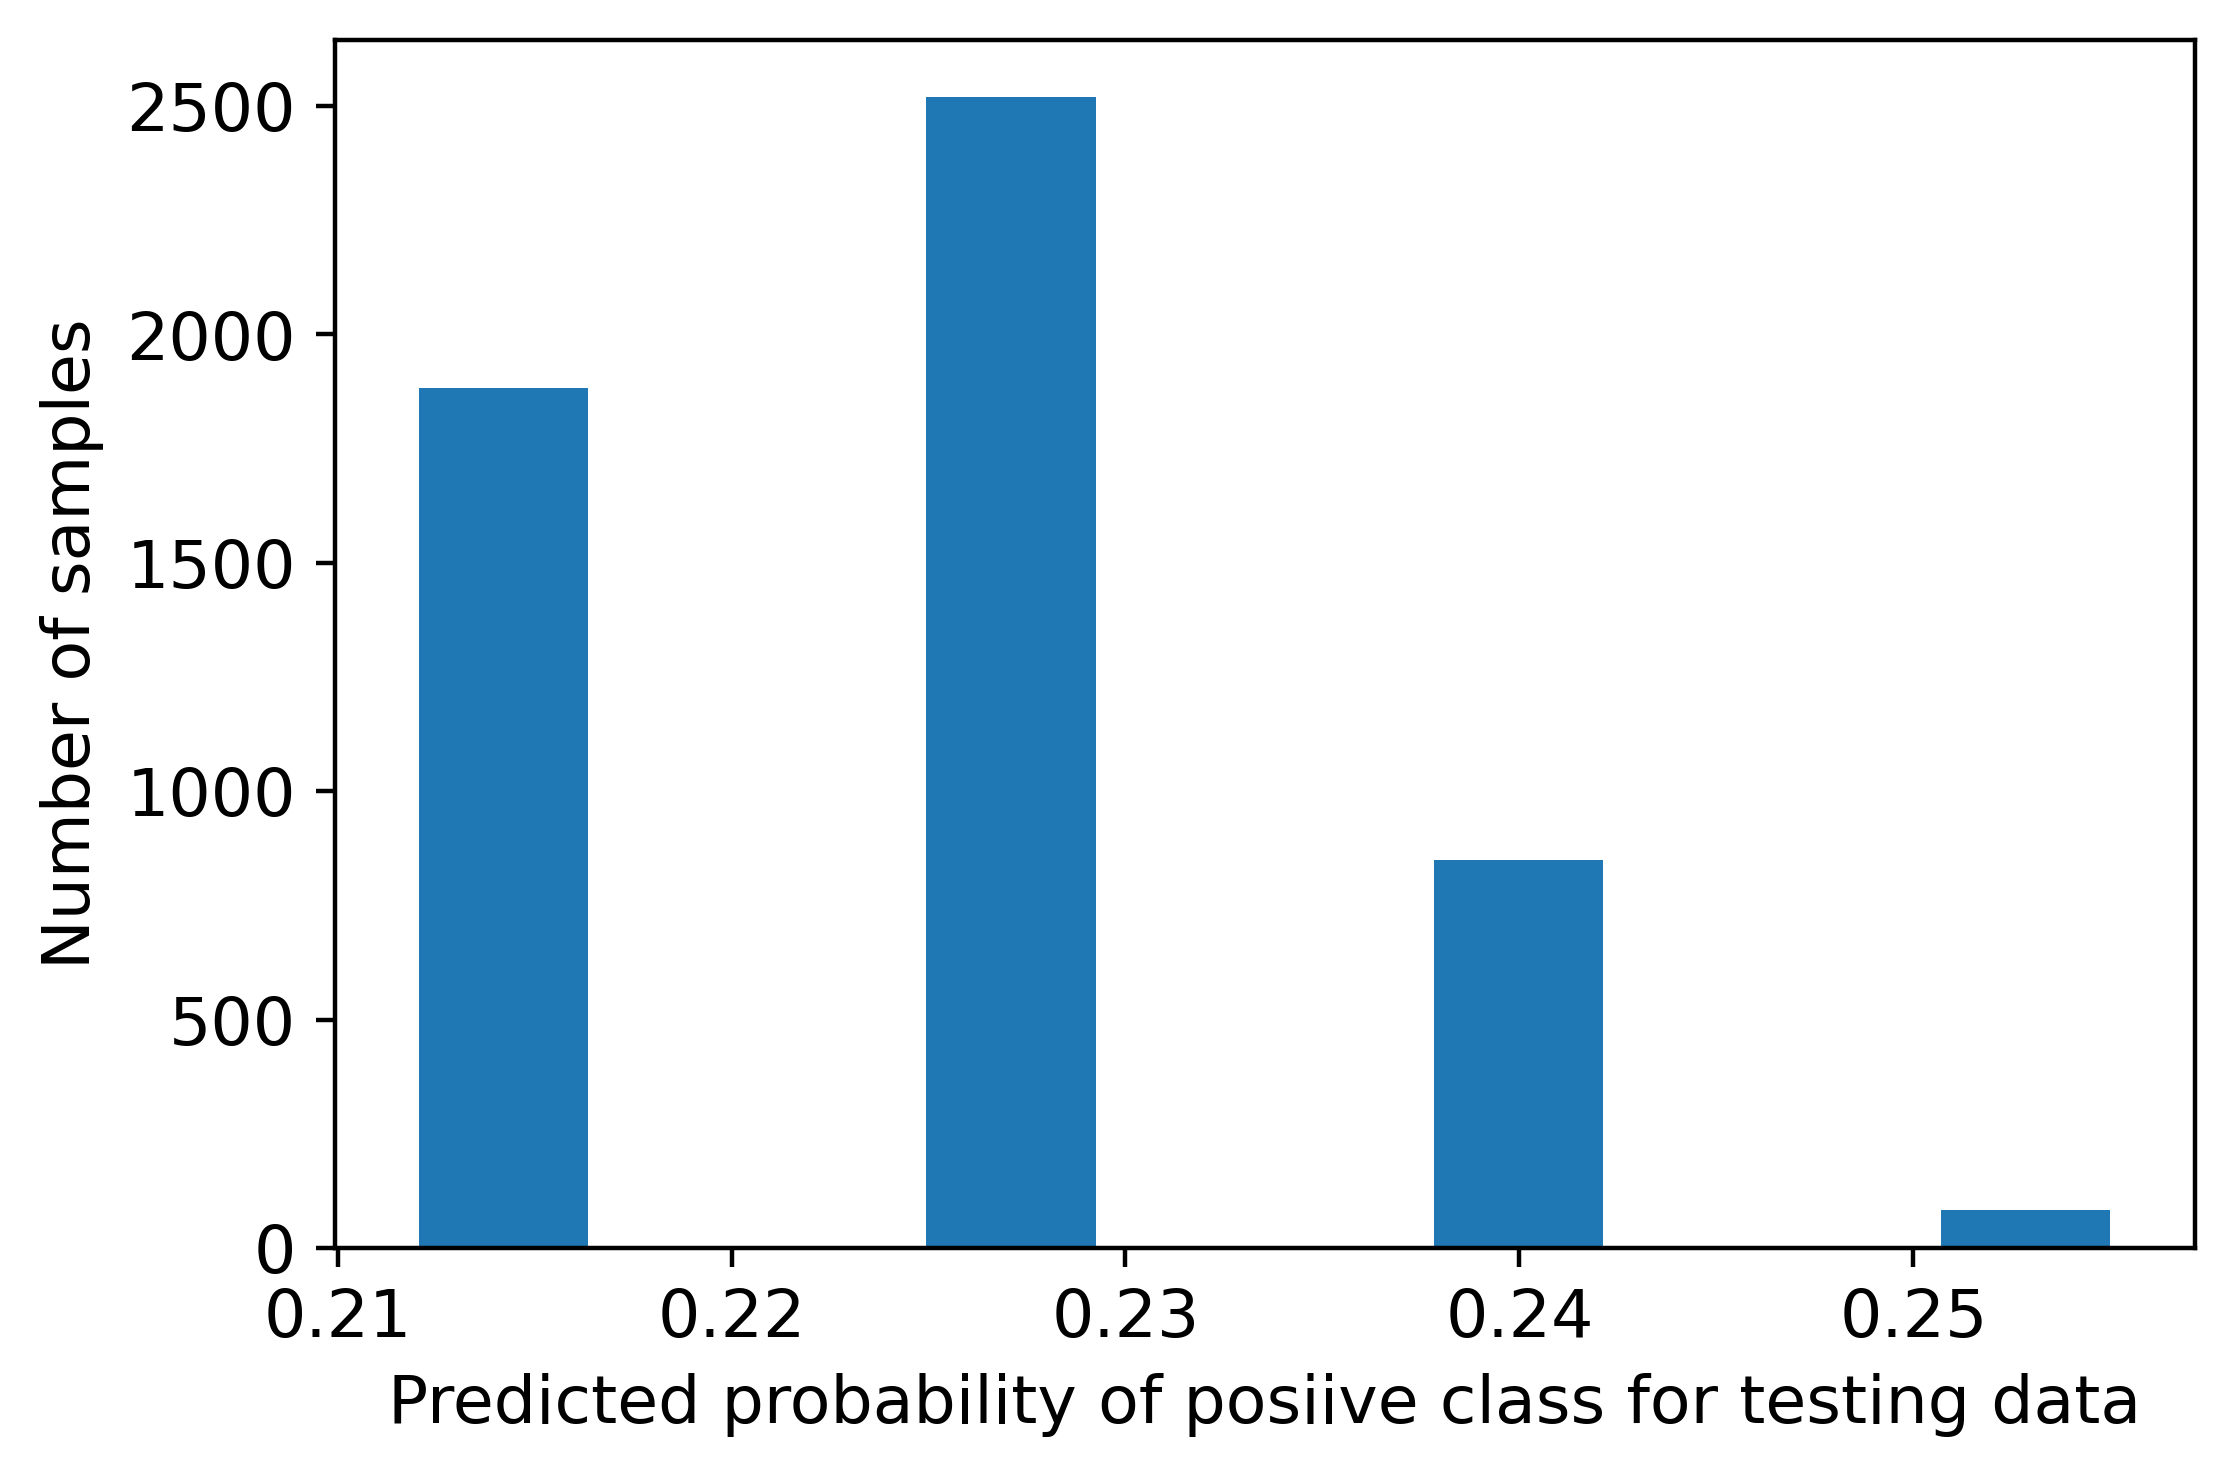

In [56]:
# Plotando um histograma das probabilidades previstas

mpl.rcParams['font.size'] = 12
plt.hist(pos_proba)
plt.xlabel('Predicted probability of posiive class for testing data')
plt.ylabel('Number of samples')

Text(0, 0.5, 'Number of samples')

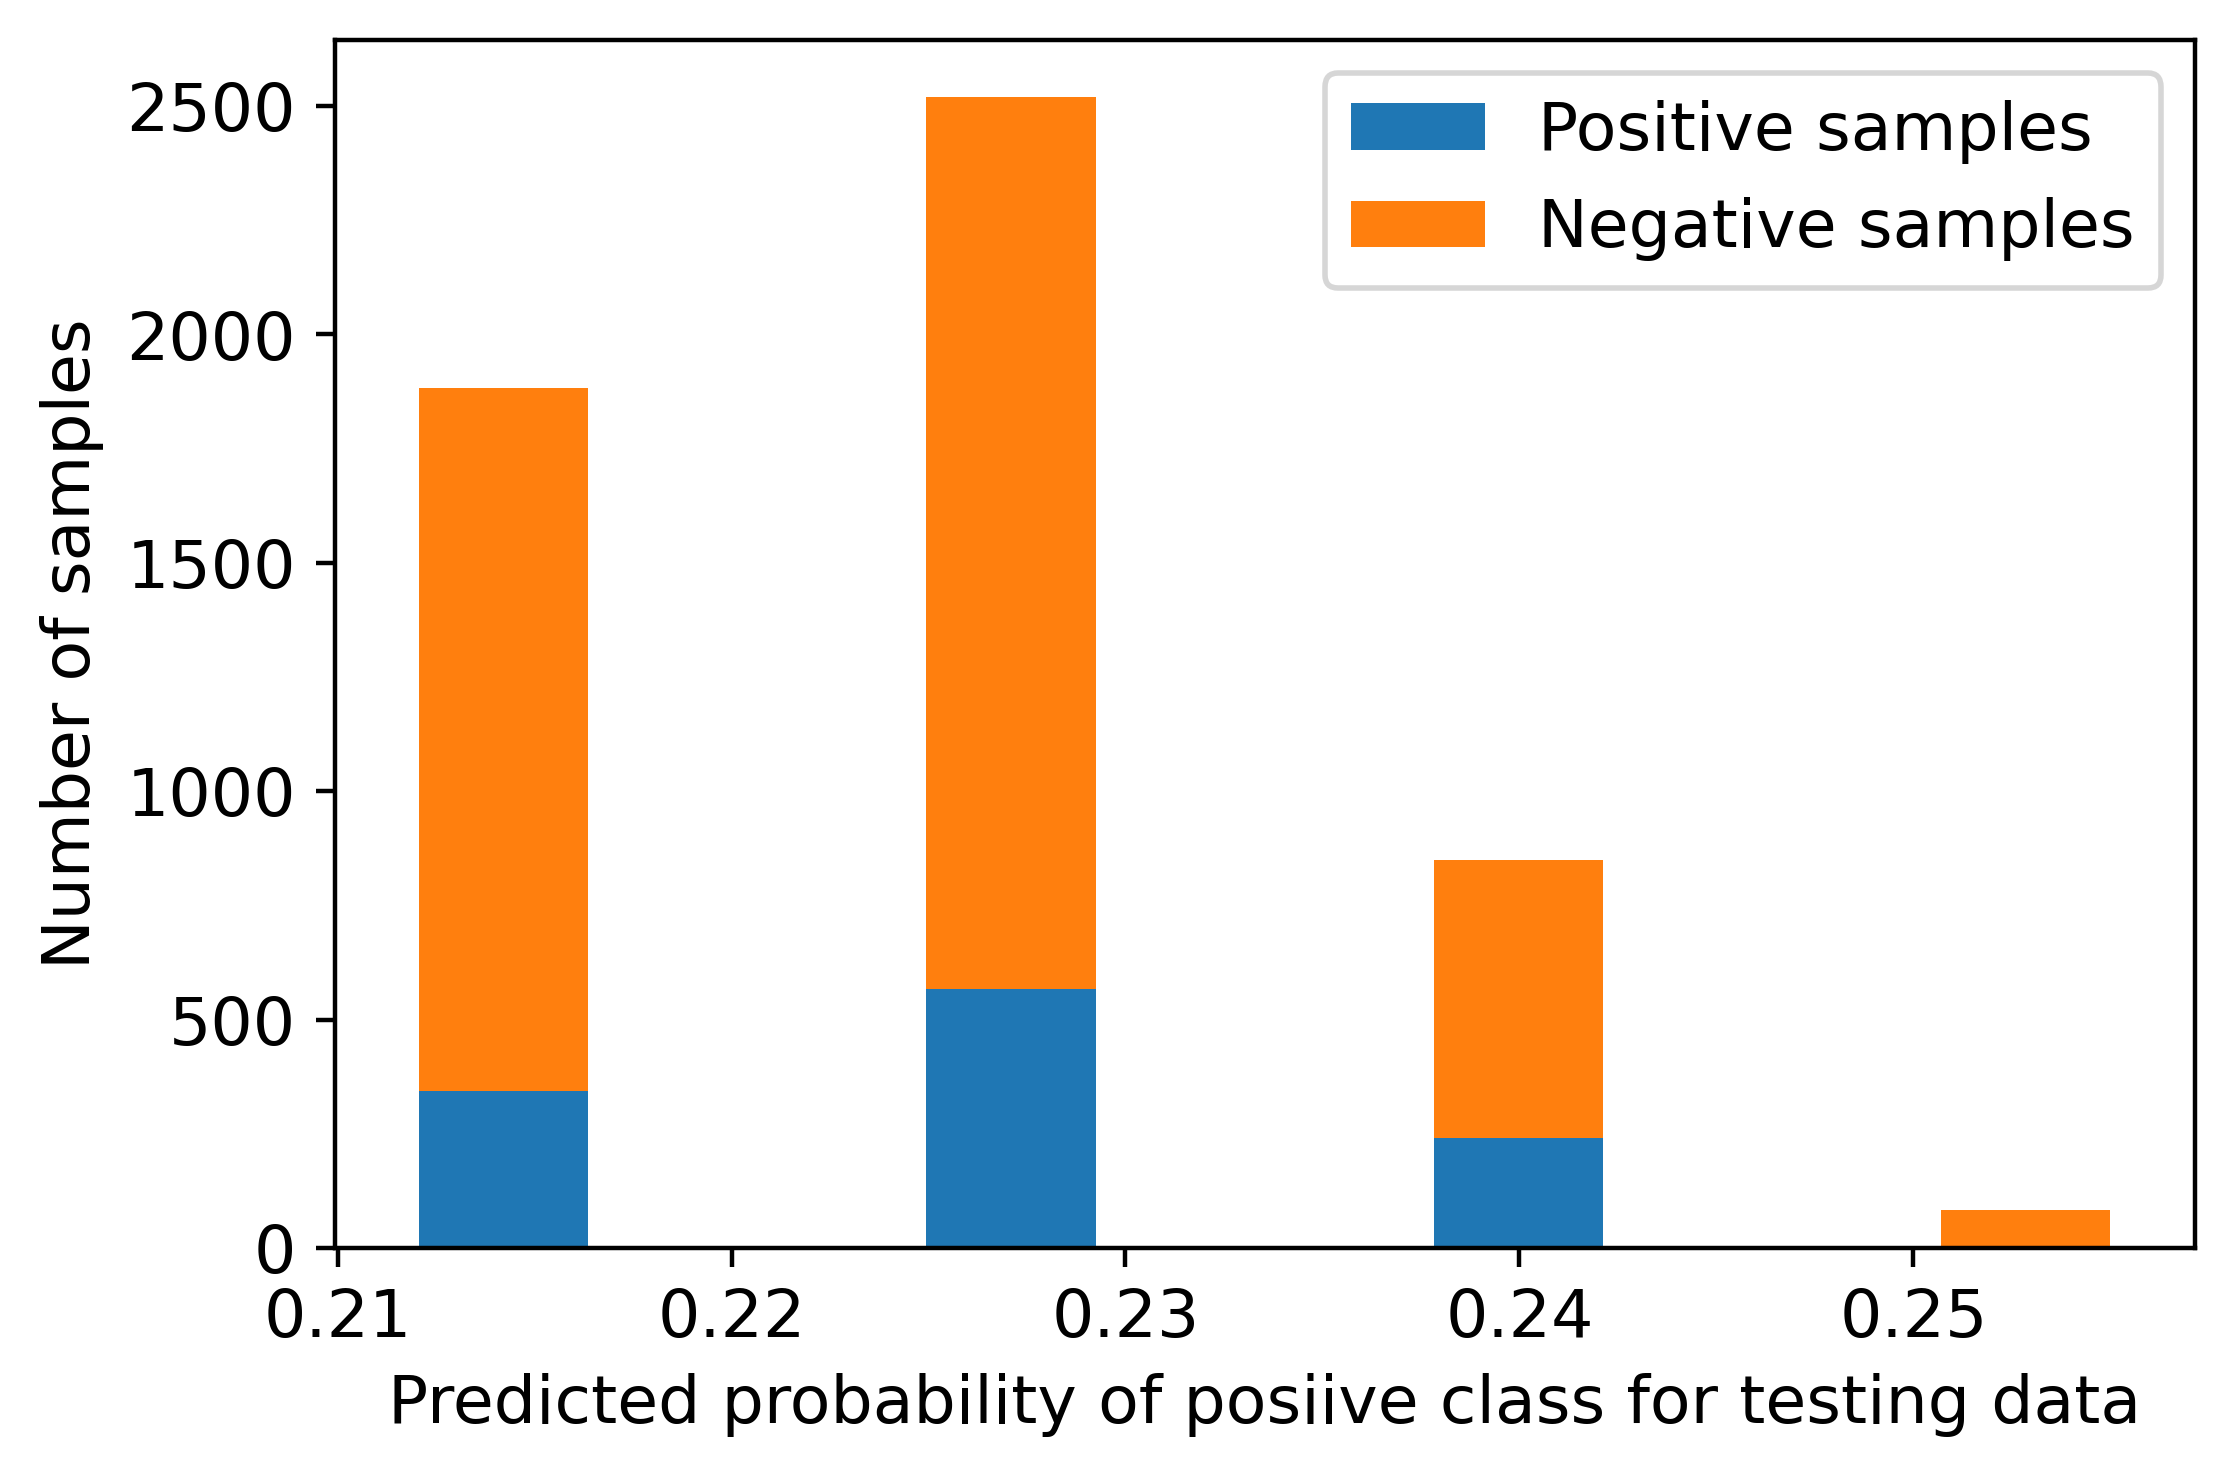

In [57]:
# Histograma empilhado de probabilidades previstas por classe

pos_sample_pos_proba = pos_proba[y_test==1]
neg_sample_pos_proba = pos_proba[y_test==0]

plt.hist([pos_sample_pos_proba, neg_sample_pos_proba], histtype='barstacked')
plt.legend(['Positive samples', 'Negative samples'])
plt.xlabel('Predicted probability of posiive class for testing data')
plt.ylabel('Number of samples')

## Curva receiver operating characteristic (ROC)

A curva ROC (característica de operação do receptor) é uma plotagem dos pares de taxa de verdadeiros positivos (eixos Y) e falsos positivos (eixo x) que resulta da diminuição do limite de 1 até 0.

Podemos deduzir que, se o limite for 1, não haverá previsões positivas, já que a regressão logísticas só prevê probabilidades estritamente entre 0 e 1 (as extremidades não são incluídas).

Text(0.5, 1.0, 'ROC curve')

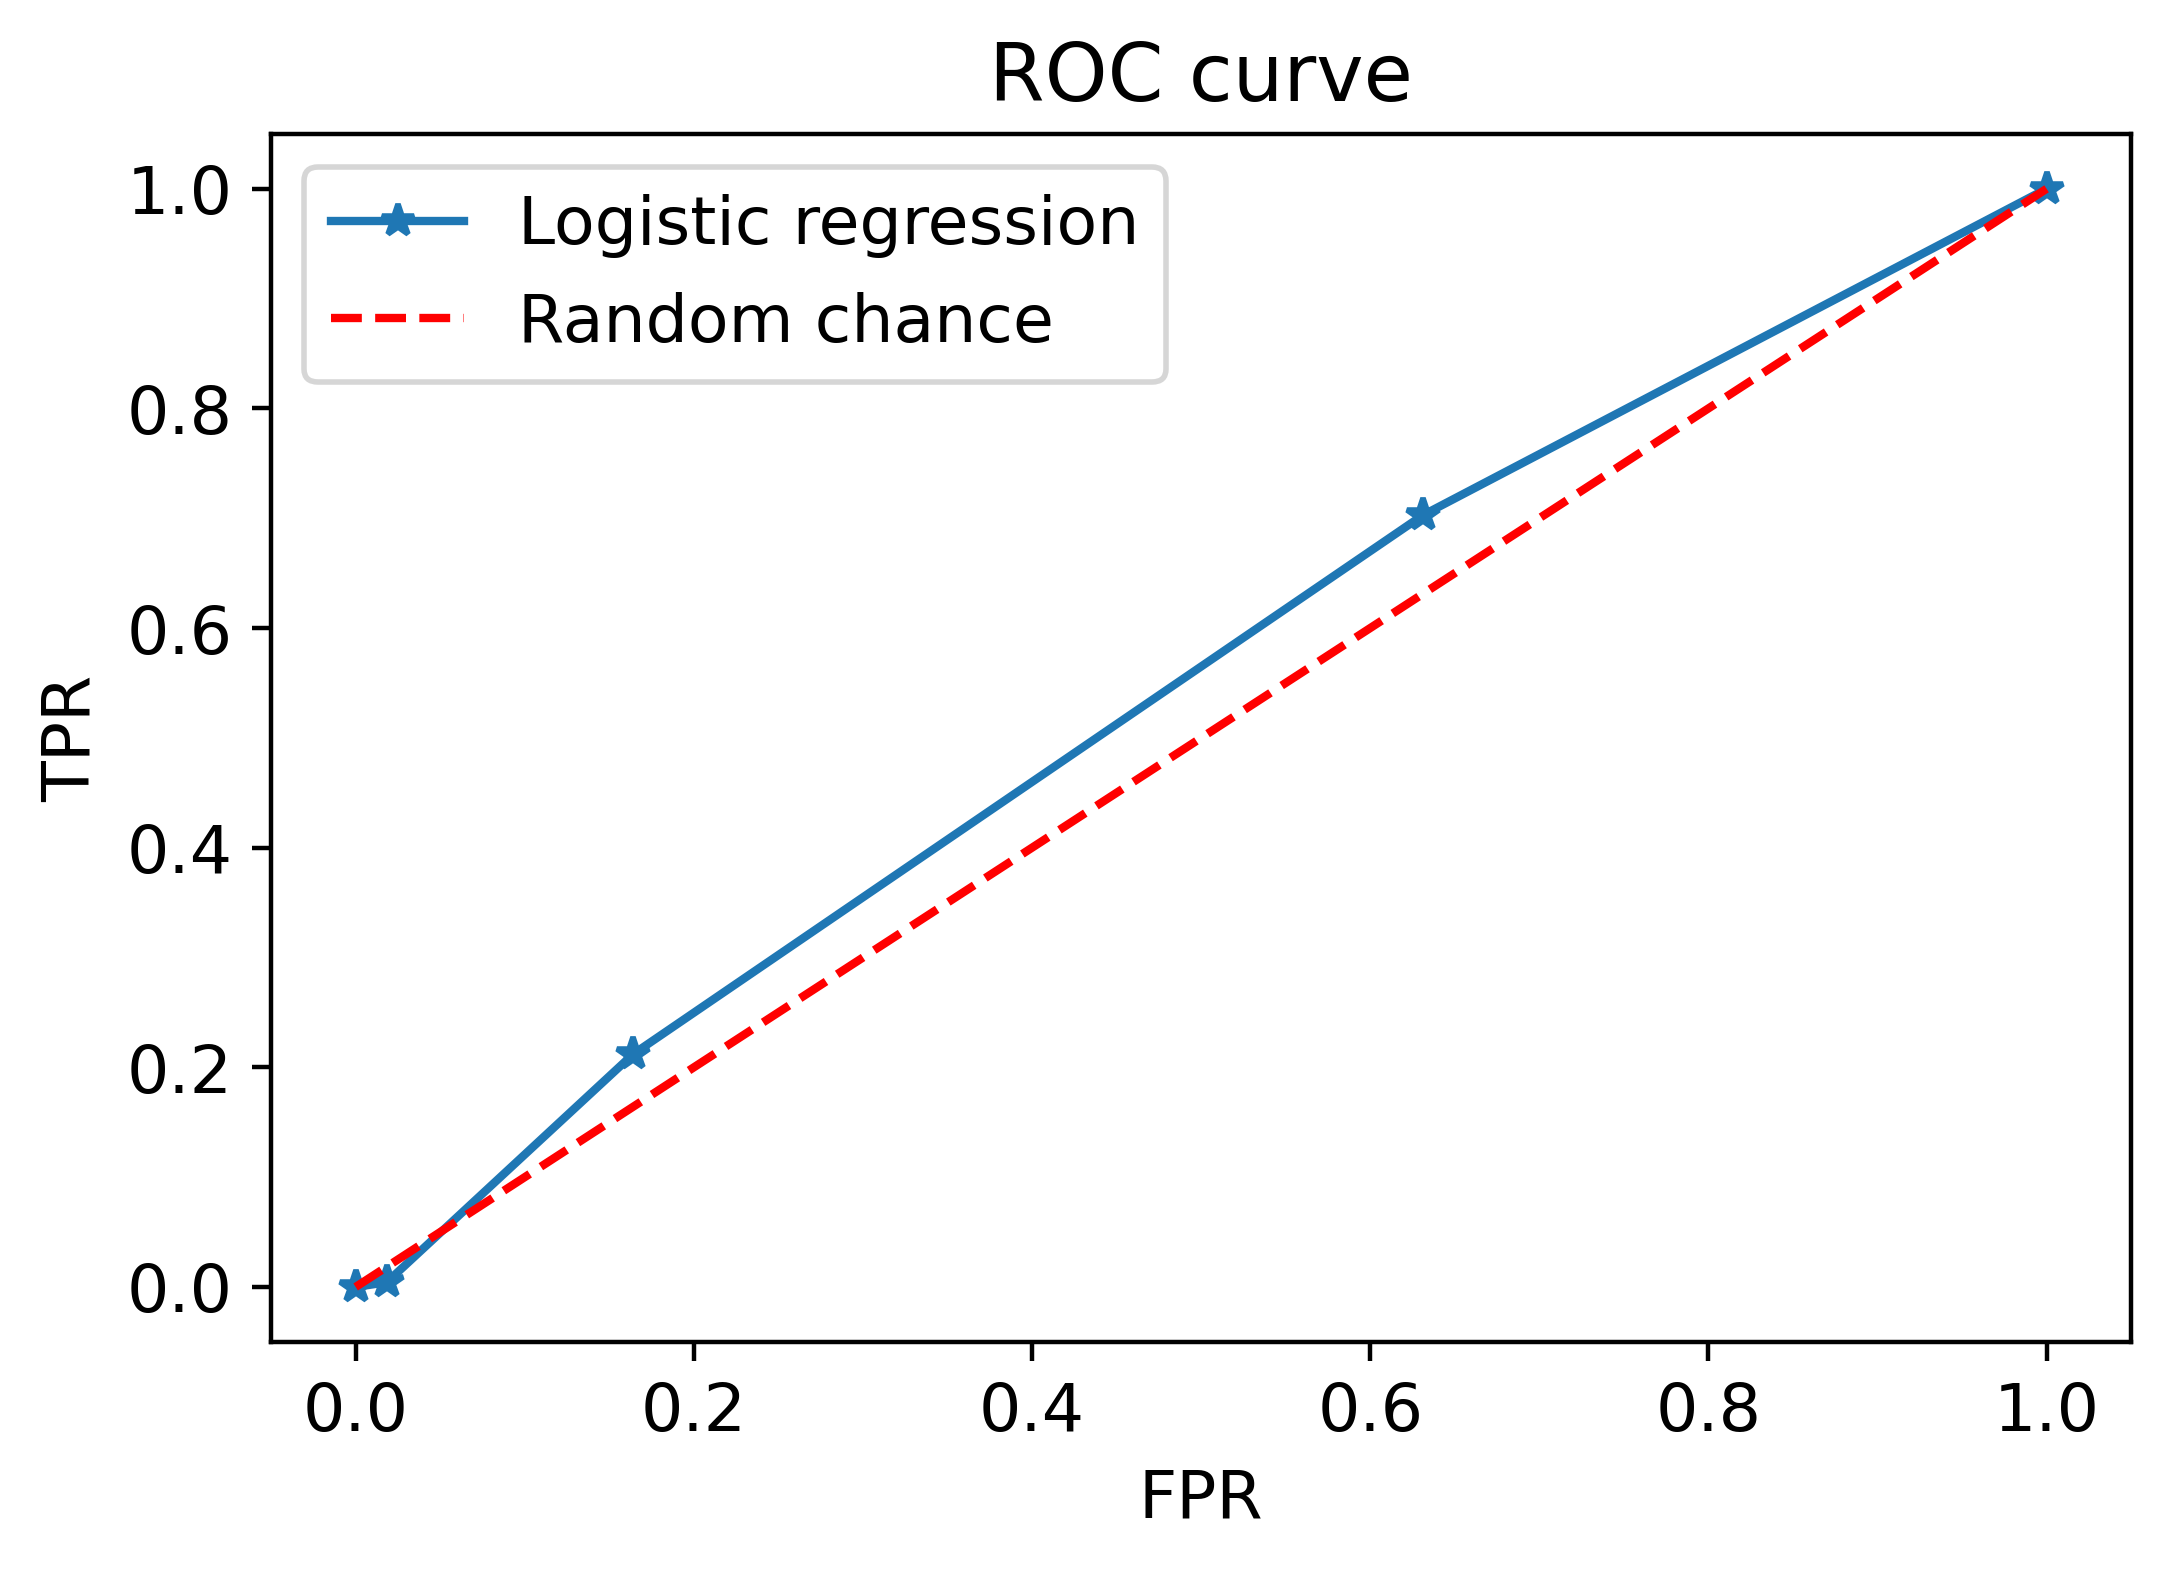

In [58]:
# Curva ROC de nossa regressão logística, com uma linha de chance aleatória sendo exibida a título de comparação

fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_proba)

plt.plot(fpr, tpr, '*-')
plt.plot([0,1], [0,1], 'r--')

plt.legend(['Logistic regression', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

**O que aprendemos com nossa curva ROC?**

Podemos ver que ela começa em (0,0) com um limite suficientemente alto que não haja classificações positivas.

Em seguida, a primeira coisa que acontence, como imaginamos anteriomente ao diminuir o limite para aproximadamente 0.25, é um aumento na taxa de falsos positiviso, mas um aumento muito menor na taxa de verdadeiros positivos.

Os efeitos de continuarmos a diminuir o limite pra que as outras barras de nosso histograma empilhado sejam incluídas como classificações positivas são mostrados pelos pontos subsequentes na linha.

In [59]:
# limites da curva ROC

thresholds

array([1.2549944 , 0.2549944 , 0.24007604, 0.22576598, 0.21207085])

In [61]:
# ROC AUC da regressão logística

metrics.roc_auc_score(y_test, pos_proba)

0.5434650477972642

# Atividade 2 - Executando a regressão logística com uma nova característica e criando uma curva precision-recall

página 104